# Analiza cen mieszkań w Polsce

Ten notatnik analizuje zbiór danych o cenach mieszkań w Polsce.

## O zbiorze danych
Zbiór danych zawiera oferty sprzedaży i wynajmu mieszkań z 15 największych miast w Polsce (Warszawa, Łódź, Kraków, Wrocław, Poznań, Gdańsk, Szczecin, Bydgoszcz, Lublin, Katowice, Białystok, Częstochowa). Dane pochodzą z lokalnych portali internetowych z ofertami sprzedaży mieszkań. Aby lepiej scharakteryzować otoczenie każdego mieszkania, każda oferta została wzbogacona o dane z Open Street Map z odległościami do punktów użyteczności publicznej (POI). Dane są zbierane co miesiąc i obejmują okres od sierpnia 2023 do czerwca 2024.

### Pliki
* `apartments_pl_RRRR_MM.csv` - miesięczny snapshot ofert sprzedaży
* `apartments_rent_pl_RRRR_MM.csv` - miesięczny snapshot ofert wynajmu

### Pola danych
* `city` - nazwa miasta, w którym znajduje się nieruchomość
* `type` - rodzaj budynku
* `squareMeters` - powierzchnia mieszkania w metrach kwadratowych
* `rooms` - liczba pokoi w mieszkaniu
* `floor` / `floorCount` - piętro, na którym znajduje się mieszkanie i łączna liczba pięter w budynku
* `buildYear` - rok budowy budynku
* `latitude`, `longitude` - współrzędne geograficzne nieruchomości
* `centreDistance` - odległość od centrum miasta w km
* `poiCount` - liczba punktów użyteczności publicznej w promieniu 500m od mieszkania (szkoły, przychodnie, poczty, przedszkola, restauracje, uczelnie, apteki)
* `[poiName]Distance` - odległość do najbliższego punktu użyteczności publicznej (szkoły, przychodnie, poczty, przedszkola, restauracje, uczelnie, apteki)
* `ownership` - rodzaj własności nieruchomości
* `condition` - stan mieszkania
* `has[features]` - czy nieruchomość posiada kluczowe udogodnienia, takie jak przypisane miejsce parkingowe, balkon, winda, ochrona, komórka lokatorska
* `price` - cena ofertowa w polskich złotych
    * `apartments_pl_RRRR_MM.csv`: cena sprzedaży
    * `apartments_rent_pl_RRRR_MM.csv`: miesięczny czynsz

In [1]:
import pandas as pd
import os
import re

In [5]:
# Definiowanie ścieżek
input_dir = 'raw_data'
output_dir = 'trusted_data'

# Tworzenie katalogu wyjściowego, jeśli nie istnieje
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Listy do przechowywania ramek danych
sell_dfs = []
rent_dfs = []

# Wzorzec do wyciągania roku i miesiąca z nazwy pliku
pattern = re.compile(r'.*_(\d{4})_(\d{2})\.csv')

# Przetwarzanie plików
for filename in os.listdir(input_dir):
    if filename.endswith('.csv'):
        match = pattern.search(filename)
        if not match:
            continue # Pomiń pliki, które nie pasują do wzorca

        year, month = match.groups()
        
        csv_path = os.path.join(input_dir, filename)
        df = pd.read_csv(csv_path)
        df['year'] = int(year)
        df['month'] = int(month)

        # Przenoszenie kolumn 'year' i 'month' po kolumnie 'id'
        cols = df.columns.tolist()
        id_col_name = cols[0]
        cols.remove('year')
        cols.remove('month')
        id_index = cols.index(id_col_name)
        new_cols = cols[:id_index+1] + ['year', 'month'] + cols[id_index+1:]
        df = df[new_cols]

        if filename.startswith('apartments_pl'):
            sell_dfs.append(df)
        elif filename.startswith('apartments_rent_pl'):
            rent_dfs.append(df)

# Łączenie i zapisywanie danych sprzedaży
if sell_dfs:
    sell_df_final = pd.concat(sell_dfs, ignore_index=True)
    sell_output_path = os.path.join(output_dir, 'apartments_sell.parquet')
    sell_df_final.to_parquet(sell_output_path)
    print(f"Zapisano połączone dane sprzedaży do {sell_output_path}")

# Łączenie i zapisywanie danych wynajmu
if rent_dfs:
    rent_df_final = pd.concat(rent_dfs, ignore_index=True)
    rent_output_path = os.path.join(output_dir, 'apartments_rent.parquet')
    rent_df_final.to_parquet(rent_output_path)
    print(f"Zapisano połączone dane wynajmu do {rent_output_path}")

print("Przetwarzanie zakończone.")

Zapisano połączone dane sprzedaży do trusted_data/apartments_sell.parquet
Zapisano połączone dane wynajmu do trusted_data/apartments_rent.parquet
Przetwarzanie zakończone.


In [6]:
print("Sprzedaż (apartments_sell.parquet):")
display(pd.read_parquet(sell_output_path).head())

print("Wynajem (apartments_rent.parquet):")
display(pd.read_parquet(rent_output_path).head())

Sprzedaż (apartments_sell.parquet):


Sprzedaż (apartments_sell.parquet):


,id,year,month,city,type,squareMeters,rooms,floor,floorCount,buildYear,...,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
0,71de9eb8a92ac12d7c94315228b70cfb,2023,9,szczecin,tenement,123.45,4.0,2.0,3.0,NaN,...,0.321,condominium,brick,None,no,yes,no,no,yes,799000
1,23d558163bb1c7863c73485048e50858,2023,9,szczecin,None,53.80,2.0,5.0,5.0,NaN,...,0.073,cooperative,None,None,no,no,yes,no,no,420000
2,3b8819c6c9ffd55adfddfd5bafcc844d,2023,9,szczecin,tenement,50.00,2.0,NaN,1.0,NaN,...,0.399,condominium,brick,None,yes,no,no,no,no,350000
3,708ccd264180315a4cfe6324ed4861d0,2023,9,szczecin,blockOfFlats,55.19,2.0,1.0,2.0,2013.0,...,0.183,condominium,brick,premium,yes,yes,no,yes,yes,607000
4,8373aa373dbc3fe7ca3b7434166b8766,2023,9,szczecin,tenement,73.02,3.0,2.0,3.0,NaN,...,0.280,condominium,brick,None,no,no,no,no,no,565000


Sprzedaż (apartments_sell.parquet):


,id,year,month,city,type,squareMeters,rooms,floor,floorCount,buildYear,...,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
0,71de9eb8a92ac12d7c94315228b70cfb,2023,9,szczecin,tenement,123.45,4.0,2.0,3.0,NaN,...,0.321,condominium,brick,None,no,yes,no,no,yes,799000
1,23d558163bb1c7863c73485048e50858,2023,9,szczecin,None,53.80,2.0,5.0,5.0,NaN,...,0.073,cooperative,None,None,no,no,yes,no,no,420000
2,3b8819c6c9ffd55adfddfd5bafcc844d,2023,9,szczecin,tenement,50.00,2.0,NaN,1.0,NaN,...,0.399,condominium,brick,None,yes,no,no,no,no,350000
3,708ccd264180315a4cfe6324ed4861d0,2023,9,szczecin,blockOfFlats,55.19,2.0,1.0,2.0,2013.0,...,0.183,condominium,brick,premium,yes,yes,no,yes,yes,607000
4,8373aa373dbc3fe7ca3b7434166b8766,2023,9,szczecin,tenement,73.02,3.0,2.0,3.0,NaN,...,0.280,condominium,brick,None,no,no,no,no,no,565000


Wynajem (apartments_rent.parquet):


,id,year,month,city,type,squareMeters,rooms,floor,floorCount,buildYear,...,pharmacyDistance,ownership,buildingMaterial,condition,hasParkingSpace,hasBalcony,hasElevator,hasSecurity,hasStorageRoom,price
0,2a1a6db97ff122d6bc148abb6f0e498a,2024,1,szczecin,blockOfFlats,52.0,2.0,3.0,3.0,2008.0,...,0.307,condominium,brick,None,yes,yes,no,no,no,3500
1,368e16142922433c709e6921a3b8f2a8,2024,1,szczecin,blockOfFlats,70.0,3.0,7.0,11.0,1985.0,...,0.086,condominium,concreteSlab,premium,no,yes,yes,no,no,2900
2,655acd54eb518a718fd1f59fd7161c61,2024,1,szczecin,blockOfFlats,43.0,2.0,3.0,3.0,1960.0,...,0.338,condominium,concreteSlab,premium,no,yes,no,no,yes,2900
3,99f85bbc55d110aa5a79ad4c7d5a0562,2024,1,szczecin,blockOfFlats,46.7,2.0,1.0,4.0,1980.0,...,0.096,condominium,concreteSlab,premium,no,no,no,no,yes,2400
4,601b83a79fb6b89fe8e488bfcdd5e872,2024,1,szczecin,None,56.2,3.0,1.0,4.0,NaN,...,0.050,condominium,None,None,no,no,None,no,no,3000


## Eksploracyjna Analiza Danych (EDA)

W tej sekcji przeprowadzimy eksploracyjną analizę danych dla zbioru ofert sprzedaży oraz wynajmu mieszkań, korzystając z przygotowanych plików parquet.

In [25]:
# Wczytanie danych sprzedaży
sell_df = pd.read_parquet(os.path.join(output_dir, 'apartments_sell.parquet'))

# Podstawowe informacje o zbiorze danych
print("Informacje o zbiorze danych sprzedaży:")
sell_df.info()

# Statystyki opisowe
print("\nStatystyki opisowe dla danych sprzedaży:")
display(sell_df.describe())

# Sprawdzenie brakujących wartości
print("\nBrakujące wartości w danych sprzedaży:")
display(sell_df.isnull().sum())

Informacje o zbiorze danych sprzedaży:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195568 entries, 0 to 195567
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    195568 non-null  object 
 1   year                  195568 non-null  int64  
 2   month                 195568 non-null  int64  
 3   city                  195568 non-null  object 
 4   type                  153307 non-null  object 
 5   squareMeters          195568 non-null  float64
 6   rooms                 195568 non-null  float64
 7   floor                 160974 non-null  float64
 8   floorCount            193185 non-null  float64
 9   buildYear             163352 non-null  float64
 10  latitude              195568 non-null  float64
 11  longitude             195568 non-null  float64
 12  centreDistance        195568 non-null  float64
 13  poiCount              195568 non-null  float64
 14  schoolDistanc

,year,month,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,schoolDistance,clinicDistance,postOfficeDistance,kindergartenDistance,restaurantDistance,collegeDistance,pharmacyDistance,price
count,195568.000000,195568.000000,195568.000000,195568.000000,160974.000000,193185.000000,163352.000000,195568.000000,195568.000000,195568.000000,195568.000000,195400.000000,194840.000000,195320.000000,195361.000000,195089.000000,190132.00000,195291.000000,1.955680e+05
mean,2023.563441,6.420401,58.697667,2.679222,3.332414,5.309113,1985.976346,52.026288,19.465989,4.351114,20.672037,0.412651,0.970287,0.516340,0.367560,0.345257,1.44327,0.358114,7.841833e+05
std,0.495960,3.477459,21.407206,0.915024,2.531684,3.312234,33.812810,1.335275,1.783264,2.835764,24.325708,0.464193,0.888884,0.498013,0.444673,0.463510,1.10457,0.457679,4.097092e+05
min,2023.000000,1.000000,25.000000,1.000000,1.000000,1.000000,1850.000000,49.978999,14.447100,0.010000,0.000000,0.002000,0.001000,0.001000,0.001000,0.001000,0.00400,0.001000,1.500000e+05
25%,2023.000000,3.000000,44.000000,2.000000,2.000000,3.000000,1967.000000,51.108796,18.523270,2.010000,7.000000,0.176000,0.356000,0.239000,0.156000,0.114000,0.57700,0.142000,5.200000e+05
50%,2024.000000,6.000000,54.600000,3.000000,3.000000,4.000000,1994.000000,52.194596,19.899434,3.980000,14.000000,0.290000,0.676000,0.393000,0.262000,0.229000,1.12000,0.239000,6.990000e+05
75%,2024.000000,10.000000,68.550000,3.000000,4.000000,6.000000,2016.000000,52.409006,20.989907,6.150000,24.000000,0.468000,1.237000,0.623000,0.416000,0.409000,2.05500,0.406000,9.300000e+05
max,2024.000000,12.000000,150.000000,6.000000,29.000000,29.000000,2024.000000,54.606460,23.208873,16.940000,212.000000,4.946000,4.999000,4.970000,4.961000,4.985000,5.00000,4.992000,3.250000e+06



Brakujące wartości w danych sprzedaży:


id                           0
year                         0
month                        0
city                         0
type                     42261
squareMeters                 0
rooms                        0
floor                    34594
floorCount                2383
buildYear                32216
latitude                     0
longitude                    0
centreDistance               0
poiCount                     0
schoolDistance             168
clinicDistance             728
postOfficeDistance         248
kindergartenDistance       207
restaurantDistance         479
collegeDistance           5436
pharmacyDistance           277
ownership                    0
buildingMaterial         77382
condition               146307
hasParkingSpace              0
hasBalcony                   0
hasElevator               9702
hasSecurity                  0
hasStorageRoom               0
price                        0
dtype: int64

### Wizualizacje dla danych sprzedaży

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ustawienia wizualizacji
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

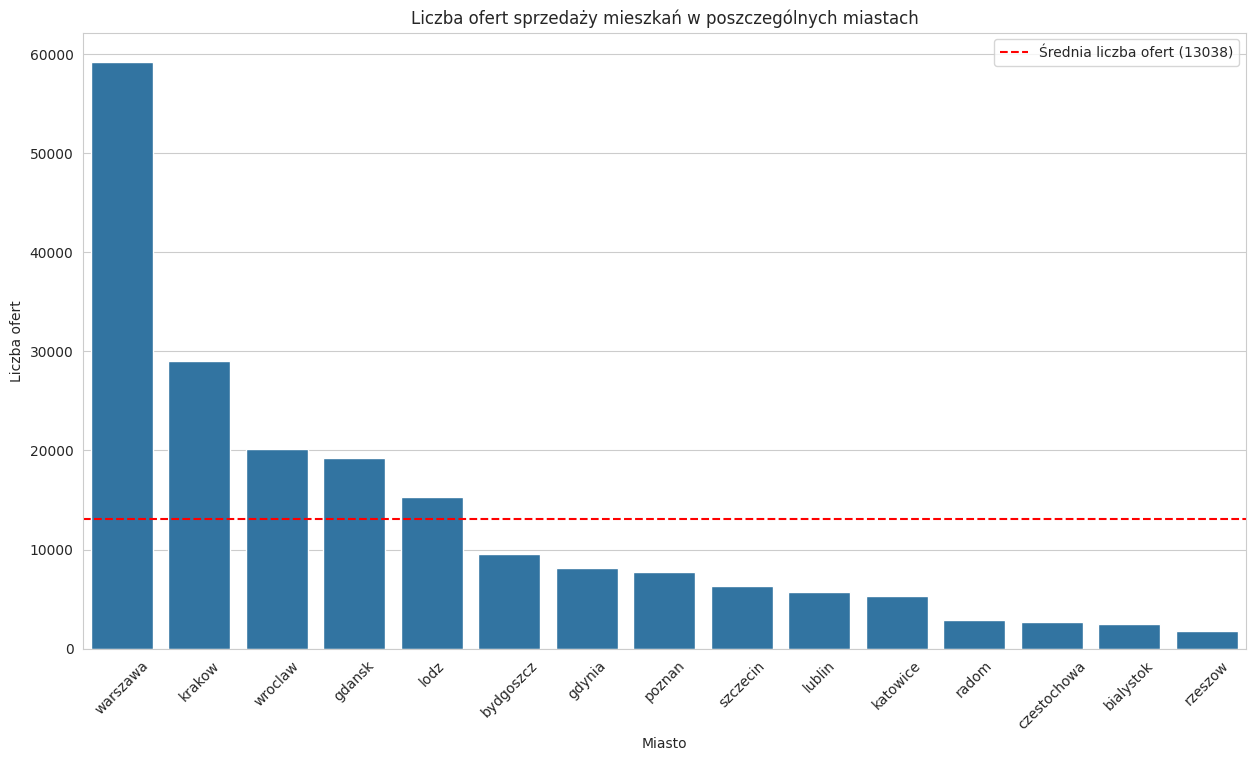

In [27]:
# Liczba ofert w poszczególnych miastach
offers_by_city = sell_df['city'].value_counts()
average_offers = offers_by_city.mean()

plt.figure(figsize=(15, 8))
sns.barplot(x=offers_by_city.index, y=offers_by_city.values)
plt.axhline(y=average_offers, color='r', linestyle='--', label=f'Średnia liczba ofert ({average_offers:.0f})')
plt.title('Liczba ofert sprzedaży mieszkań w poszczególnych miastach')
plt.xlabel('Miasto')
plt.ylabel('Liczba ofert')
plt.xticks(rotation=45)
plt.legend()
plt.show()

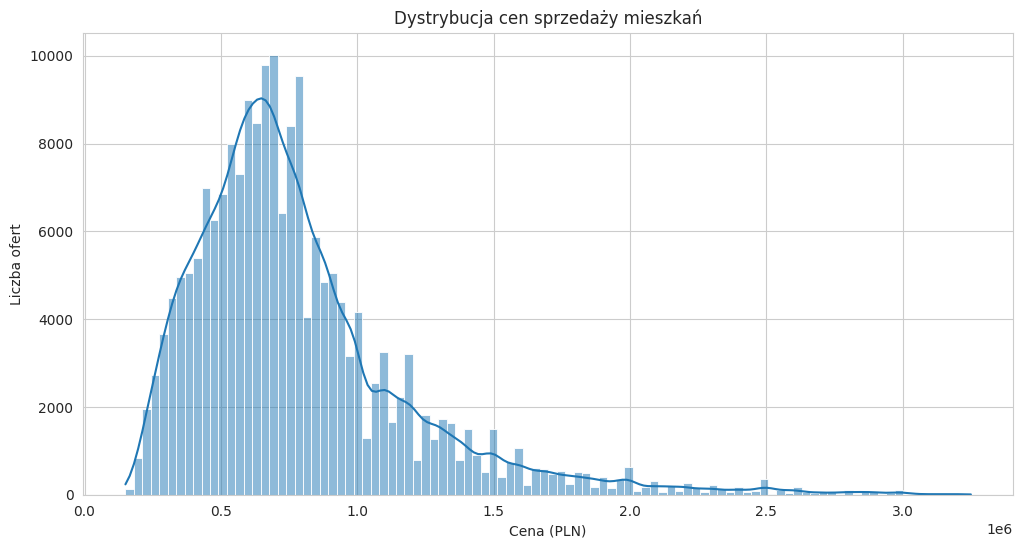

In [28]:
# Dystrybucja ceny
plt.figure(figsize=(12, 6))
sns.histplot(sell_df['price'], bins=100, kde=True)
plt.title('Dystrybucja cen sprzedaży mieszkań')
plt.xlabel('Cena (PLN)')
plt.ylabel('Liczba ofert')
plt.show()

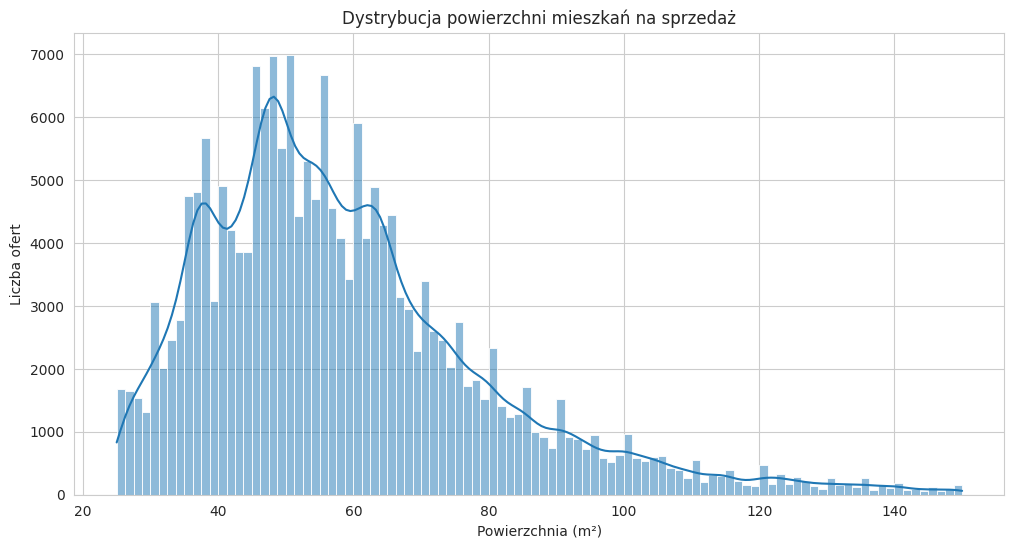

In [29]:
# Dystrybucja powierzchni
plt.figure(figsize=(12, 6))
sns.histplot(sell_df['squareMeters'], bins=100, kde=True)
plt.title('Dystrybucja powierzchni mieszkań na sprzedaż')
plt.xlabel('Powierzchnia (m²)')
plt.ylabel('Liczba ofert')
plt.show()

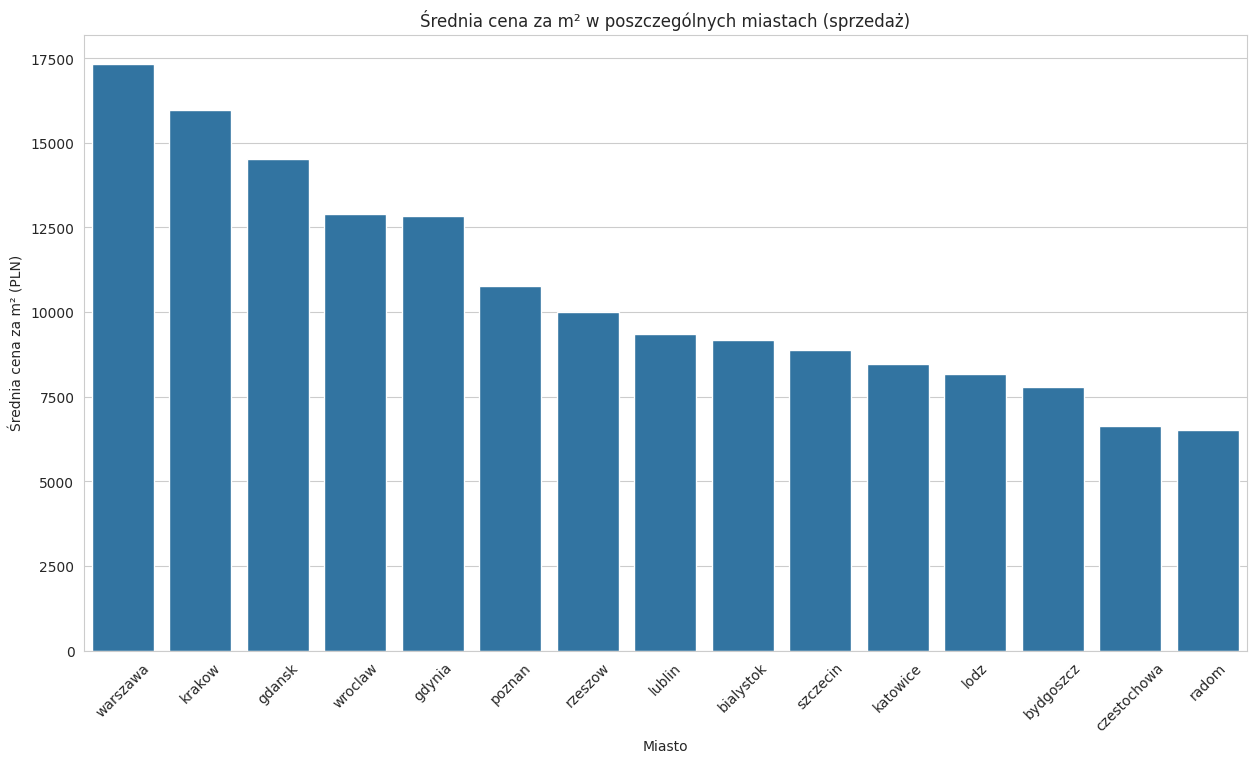

In [30]:
# Średnia cena za metr w zależności od miasta
sell_df['price_per_m2'] = sell_df['price'] / sell_df['squareMeters']
avg_price_per_city = sell_df.groupby('city')['price_per_m2'].mean().sort_values(ascending=False)

plt.figure(figsize=(15, 8))
sns.barplot(x=avg_price_per_city.index, y=avg_price_per_city.values)
plt.title('Średnia cena za m² w poszczególnych miastach (sprzedaż)')
plt.xlabel('Miasto')
plt.ylabel('Średnia cena za m² (PLN)')
plt.xticks(rotation=45)
plt.show()

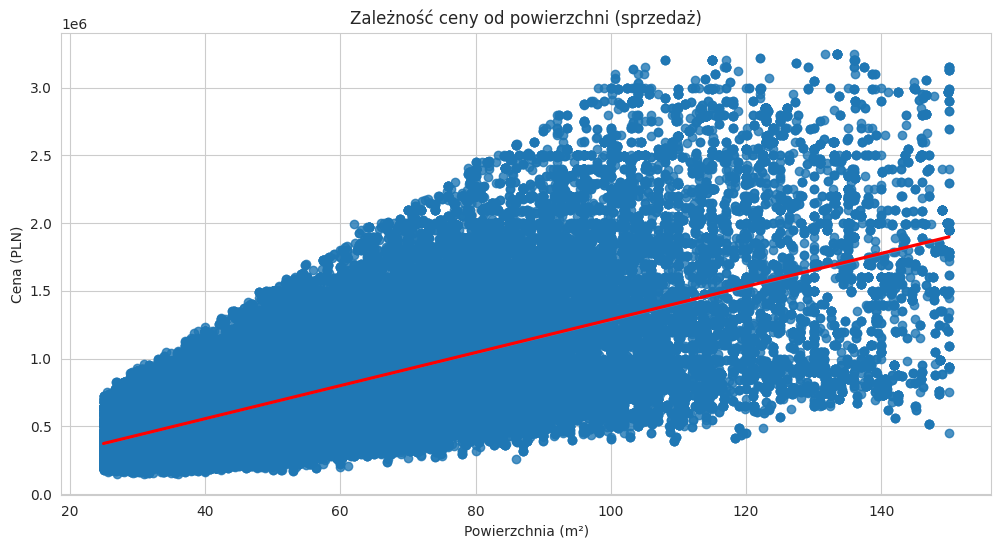

In [31]:
# Zależność ceny od powierzchni
plt.figure(figsize=(12, 6))
sns.regplot(data=sell_df[sell_df['price'] < 5000000], x='squareMeters', y='price', line_kws={"color": "red"})
plt.title('Zależność ceny od powierzchni (sprzedaż)')
plt.xlabel('Powierzchnia (m²)')
plt.ylabel('Cena (PLN)')
plt.show()

### Wnioski z analizy danych sprzedaży

Na podstawie przeprowadzonej analizy eksploracyjnej zbioru danych dotyczącego sprzedaży mieszkań, można wyciągnąć następujące wnioski:

1.  **Jakość i kompletność danych**:
    *   Zbiór danych zawiera znaczną liczbę brakujących wartości, szczególnie w kolumnach `condition` (stan), `buildYear` (rok budowy) oraz `ownership` (rodzaj własności). Wymaga to zastosowania odpowiednich strategii uzupełniania lub usuwania danych w dalszych etapach modelowania.
    *   Większość kolumn ma odpowiedni typ danych, jednak kolumny `has[...]` (cechy) oraz `type` (rodzaj budynku) mogą wymagać przekształcenia na format numeryczny (np. one-hot encoding) na potrzeby modeli uczenia maszynowego.

2.  **Rozkład danych**:
    *   **Cena (`price`)**: Rozkład cen jest silnie prawostronnie skośny, co oznacza, że większość ofert koncentruje się w niższych przedziałach cenowych, z niewielką liczbą bardzo drogich nieruchomości (tzw. "długi ogon"). Mediana ceny jest prawdopodobnie lepszą miarą tendencji centralnej niż średnia.
    *   **Powierzchnia (`squareMeters`)**: Rozkład powierzchni również jest prawostronnie skośny. Najwięcej jest mieszkań o mniejszym metrażu (prawdopodobnie 30-70 m²), a znacznie mniej dużych apartamentów.

3.  **Zależności i trendy**:
    *   **Cena za m² w miastach**: Istnieją wyraźne różnice w średnich cenach za metr kwadratowy pomiędzy miastami. Zgodnie z oczekiwaniami, Warszawa, Kraków i Gdańsk należą do najdroższych lokalizacji.
    *   **Cena vs Powierzchnia**: Widoczna jest silna, pozytywna korelacja liniowa między powierzchnią mieszkania a jego ceną. Im większe mieszkanie, tym wyższa jego cena, co jest logicznym i oczekiwanym zjawiskiem. Wykres rozrzutu z linią regresji potwierdza ten trend.

### Analiza zbioru danych wynajmu

In [32]:
# Wczytanie danych wynajmu
rent_df = pd.read_parquet(os.path.join(output_dir, 'apartments_rent.parquet'))

# Podstawowe informacje o zbiorze danych
print("Informacje o zbiorze danych wynajmu:")
rent_df.info()

# Statystyki opisowe
print("\nStatystyki opisowe dla danych wynajmu:")
display(rent_df.describe())

# Sprawdzenie brakujących wartości
print("\nBrakujące wartości w danych wynajmu:")
display(rent_df.isnull().sum())

Informacje o zbiorze danych wynajmu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70847 entries, 0 to 70846
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    70847 non-null  object 
 1   year                  70847 non-null  int64  
 2   month                 70847 non-null  int64  
 3   city                  70847 non-null  object 
 4   type                  54085 non-null  object 
 5   squareMeters          70847 non-null  float64
 6   rooms                 70847 non-null  float64
 7   floor                 62234 non-null  float64
 8   floorCount            69468 non-null  float64
 9   buildYear             51165 non-null  float64
 10  latitude              70847 non-null  float64
 11  longitude             70847 non-null  float64
 12  centreDistance        70847 non-null  float64
 13  poiCount              70847 non-null  float64
 14  schoolDistance        70832 non-n

,year,month,squareMeters,rooms,floor,floorCount,buildYear,latitude,longitude,centreDistance,poiCount,schoolDistance,clinicDistance,postOfficeDistance,kindergartenDistance,restaurantDistance,collegeDistance,pharmacyDistance,price
count,70847.000000,70847.000000,70847.000000,70847.000000,62234.000000,69468.000000,51165.000000,70847.000000,70847.000000,70847.000000,70847.000000,70832.000000,70797.000000,70821.000000,70804.000000,70693.000000,69973.000000,70767.000000,70847.000000
mean,2023.754330,5.503748,55.252692,2.384942,3.419787,5.686906,1998.109293,51.785566,19.691005,3.856228,25.207983,0.368818,0.776294,0.470210,0.327194,0.260977,1.286804,0.308887,3852.796886
std,0.430487,3.735573,22.688973,0.872078,2.647224,3.461192,30.292490,1.183777,1.675260,2.609485,27.050432,0.341474,0.724202,0.389788,0.321697,0.318860,1.016936,0.327246,2381.540981
min,2023.000000,1.000000,25.000000,1.000000,1.000000,1.000000,1850.000000,49.982150,14.447100,0.020000,0.000000,0.002000,0.001000,0.001000,0.001000,0.001000,0.004000,0.001000,346.000000
25%,2024.000000,3.000000,40.000000,2.000000,2.000000,4.000000,1984.000000,51.078600,18.651526,1.770000,9.000000,0.174000,0.302000,0.235000,0.153000,0.087000,0.520000,0.136000,2500.000000
50%,2024.000000,5.000000,50.000000,2.000000,3.000000,5.000000,2010.000000,52.185642,19.958724,3.380000,17.000000,0.285000,0.550000,0.388000,0.259000,0.180000,0.971000,0.231000,3100.000000
75%,2024.000000,6.000000,64.000000,3.000000,4.000000,7.000000,2020.000000,52.250101,21.005240,5.420000,30.000000,0.449000,0.970000,0.585000,0.401000,0.329000,1.809000,0.382000,4490.000000
max,2024.000000,12.000000,150.000000,6.000000,30.000000,30.000000,2024.000000,54.581756,23.199087,16.620000,210.000000,4.856000,4.990000,4.939000,4.751000,4.961000,5.000000,4.986000,23000.000000



Brakujące wartości w danych wynajmu:


id                          0
year                        0
month                       0
city                        0
type                    16762
squareMeters                0
rooms                       0
floor                    8613
floorCount               1379
buildYear               19682
latitude                    0
longitude                   0
centreDistance              0
poiCount                    0
schoolDistance             15
clinicDistance             50
postOfficeDistance         26
kindergartenDistance       43
restaurantDistance        154
collegeDistance           874
pharmacyDistance           80
ownership                   0
buildingMaterial        28997
condition               51665
hasParkingSpace             0
hasBalcony                  0
hasElevator              3924
hasSecurity                 0
hasStorageRoom              0
price                       0
dtype: int64

### Wizualizacje dla danych wynajmu

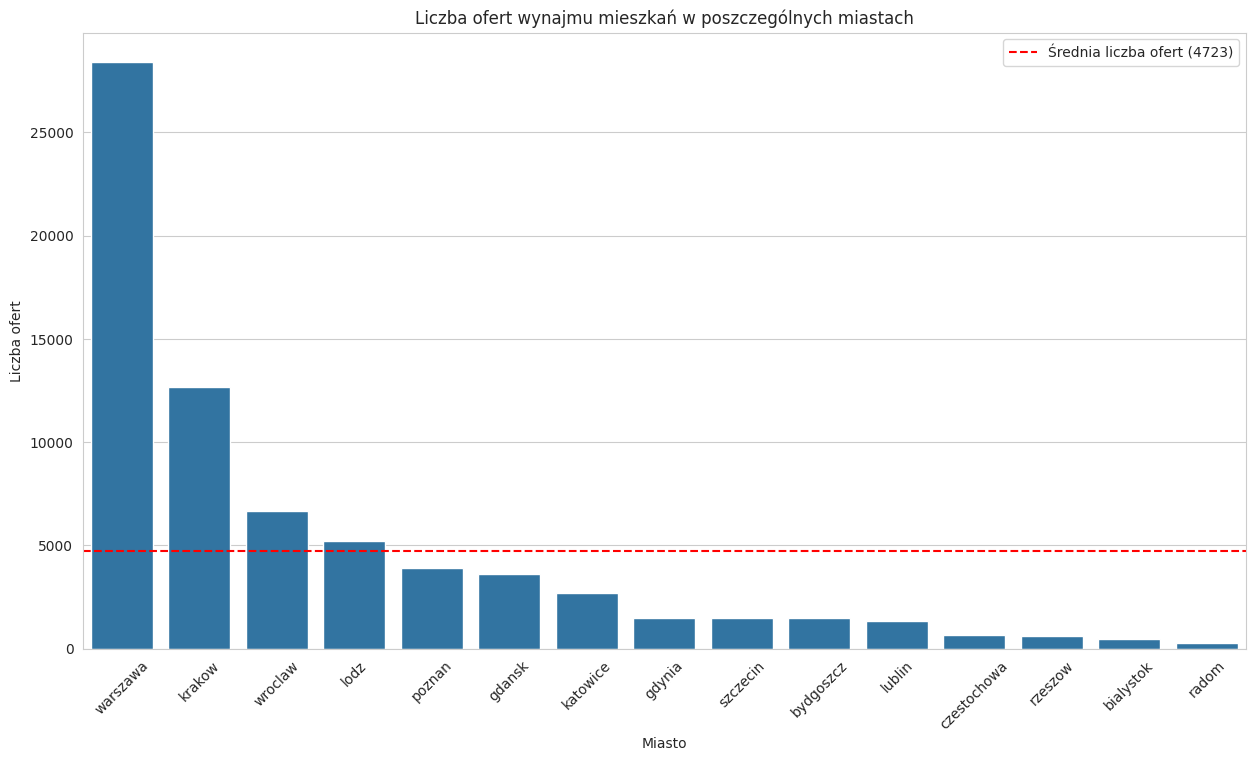

In [33]:
# Liczba ofert w poszczególnych miastach
offers_by_city_rent = rent_df['city'].value_counts()
average_offers_rent = offers_by_city_rent.mean()

plt.figure(figsize=(15, 8))
sns.barplot(x=offers_by_city_rent.index, y=offers_by_city_rent.values)
plt.axhline(y=average_offers_rent, color='r', linestyle='--', label=f'Średnia liczba ofert ({average_offers_rent:.0f})')
plt.title('Liczba ofert wynajmu mieszkań w poszczególnych miastach')
plt.xlabel('Miasto')
plt.ylabel('Liczba ofert')
plt.xticks(rotation=45)
plt.legend()
plt.show()

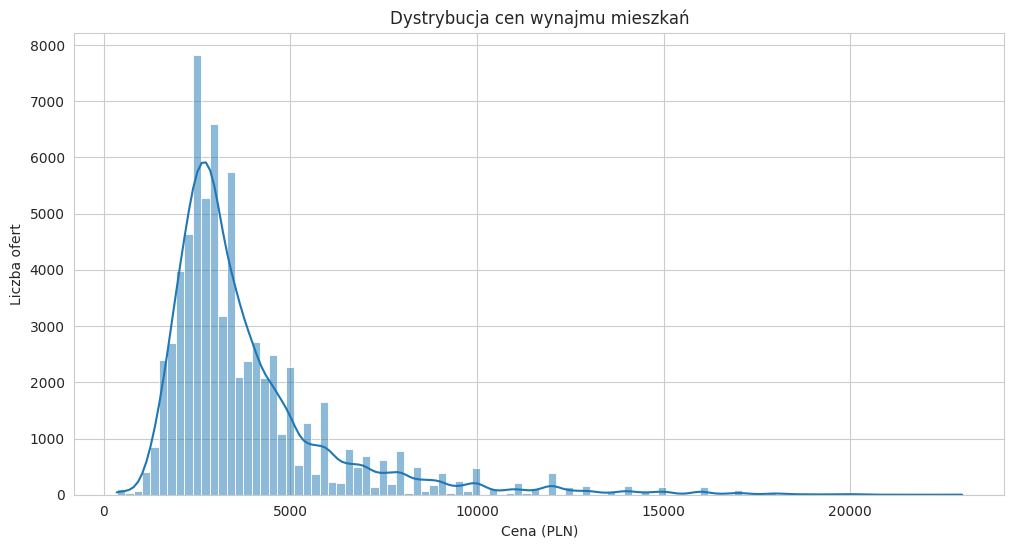

In [34]:
# Dystrybucja ceny wynajmu
plt.figure(figsize=(12, 6))
sns.histplot(rent_df['price'], bins=100, kde=True)
plt.title('Dystrybucja cen wynajmu mieszkań')
plt.xlabel('Cena (PLN)')
plt.ylabel('Liczba ofert')
plt.show()

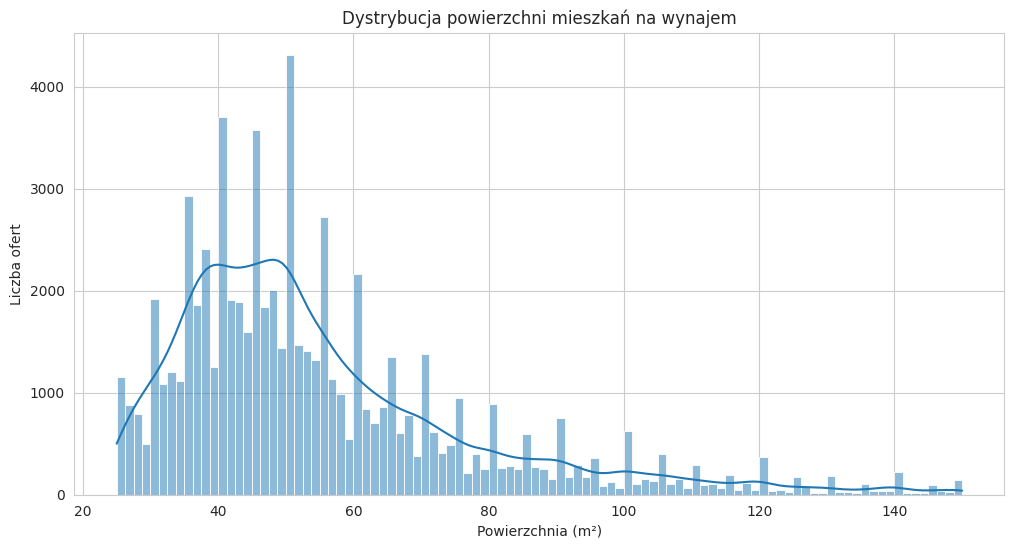

In [35]:
# Dystrybucja powierzchni
plt.figure(figsize=(12, 6))
sns.histplot(rent_df['squareMeters'], bins=100, kde=True)
plt.title('Dystrybucja powierzchni mieszkań na wynajem')
plt.xlabel('Powierzchnia (m²)')
plt.ylabel('Liczba ofert')
plt.show()

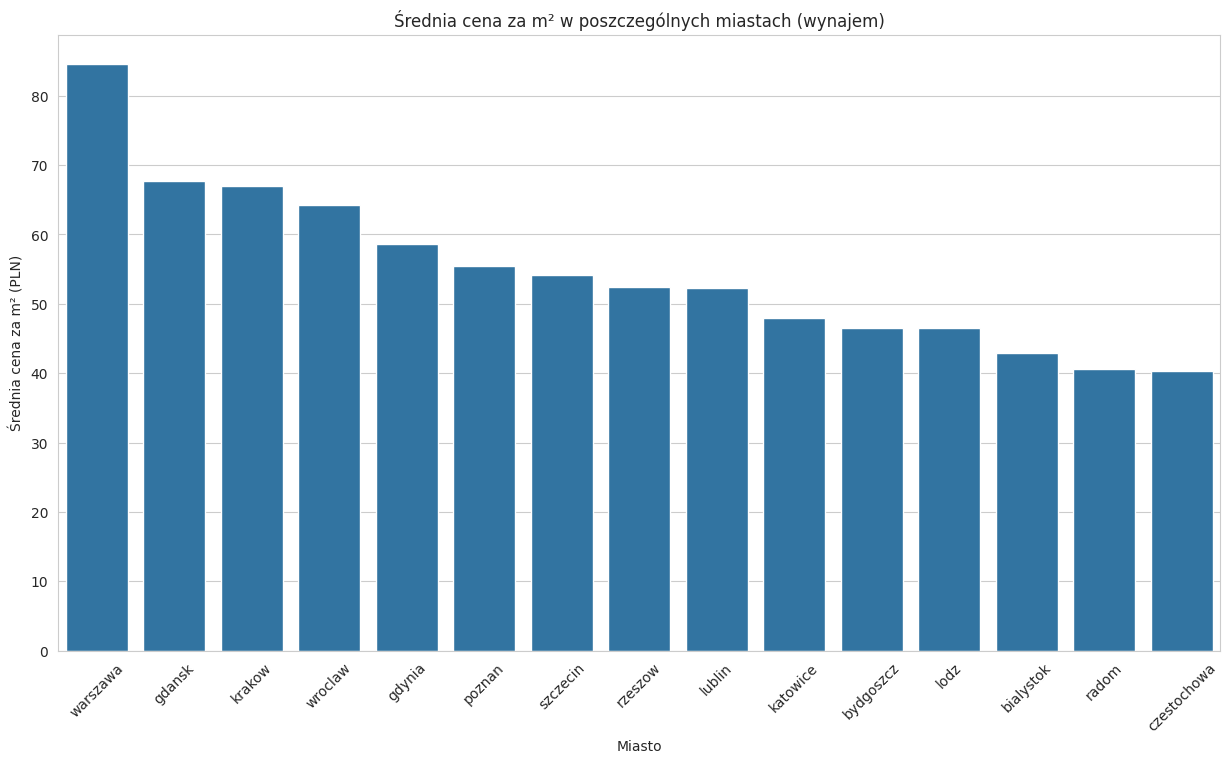

In [36]:
# Średnia cena za metr w zależności od miasta (wynajem)
rent_df['price_per_m2'] = rent_df['price'] / rent_df['squareMeters']
avg_price_per_city_rent = rent_df.groupby('city')['price_per_m2'].mean().sort_values(ascending=False)

plt.figure(figsize=(15, 8))
sns.barplot(x=avg_price_per_city_rent.index, y=avg_price_per_city_rent.values)
plt.title('Średnia cena za m² w poszczególnych miastach (wynajem)')
plt.xlabel('Miasto')
plt.ylabel('Średnia cena za m² (PLN)')
plt.xticks(rotation=45)
plt.show()

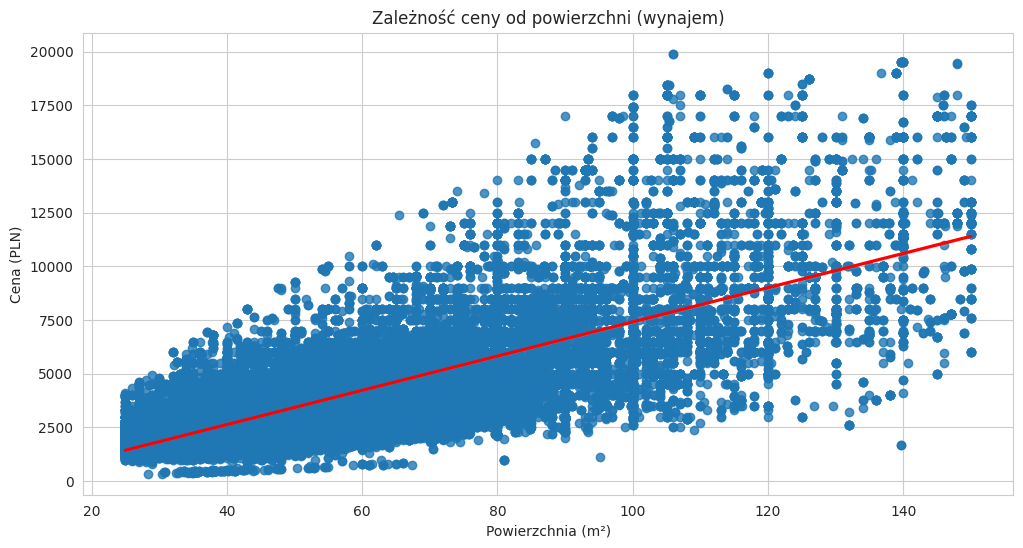

In [37]:
# Zależność ceny od powierzchni (wynajem)
plt.figure(figsize=(12, 6))
sns.regplot(data=rent_df[rent_df['price'] < 20000], x='squareMeters', y='price', line_kws={"color": "red"})
plt.title('Zależność ceny od powierzchni (wynajem)')
plt.xlabel('Powierzchnia (m²)')
plt.ylabel('Cena (PLN)')
plt.show()

### Wnioski z analizy danych wynajmu

Analiza danych dotyczących wynajmu mieszkań prowadzi do podobnych obserwacji jak w przypadku danych sprzedażowych, ale z kilkoma kluczowymi różnicami:

1.  **Jakość i kompletność danych**:
    *   Podobnie jak w zbiorze sprzedażowym, tutaj również występuje problem z brakującymi danymi, zwłaszcza dla kolumn `condition`, `buildYear` i `ownership`.
    *   Liczba ofert wynajmu jest generalnie niższa niż liczba ofert sprzedaży w analizowanym okresie.

2.  **Rozkład danych**:
    *   **Cena (`price`)**: Rozkład cen najmu jest również prawostronnie skośny, z koncentracją ofert w niższych przedziałach cenowych. Wartości odstające są mniej ekstremalne niż w przypadku cen sprzedaży.
    *   **Powierzchnia (`squareMeters`)**: Rozkład powierzchni jest bardzo podobny do tego ze zbioru sprzedażowego, co sugeruje, że typowe rozmiary mieszkań oferowanych na sprzedaż i wynajem są zbliżone.

3.  **Zależności i trendy**:
    *   **Cena za m² w miastach**: Ranking miast pod względem średniej ceny najmu za m² jest bardzo podobny do rankingu cen sprzedaży. Warszawa, Wrocław i Kraków to najdroższe miasta pod względem wynajmu.
    *   **Cena vs Powierzchnia**: Istnieje silna, pozytywna korelacja liniowa między powierzchnią a ceną najmu. Zależność ta jest równie wyraźna jak w przypadku sprzedaży.


### Podsumowanie i wnioski końcowe z EDA

Po przeprowadzeniu eksploracyjnej analizy danych dla obu zbiorów (`apartments_sell.parquet` i `apartments_rent.parquet`) można sformułować następujące ogólne wnioski i zaplanować kolejne kroki:

**Wspólne cechy obu zbiorów danych:**

1.  **Problem z brakującymi danymi**: Oba zbiory cierpią na znaczną liczbę brakujących wartości, szczególnie w kluczowych kolumnach opisujących nieruchomość, takich jak `condition`, `buildYear` i `ownership`. Jest to najważniejsze wyzwanie, którym należy się zająć przed modelowaniem.
2.  **Podobne rozkłady kluczowych zmiennych**: Zarówno ceny sprzedaży, jak i wynajmu, a także powierzchnia mieszkań, mają rozkłady prawostronnie skośne. Oznacza to, że większość ofert skupia się wokół niższych wartości, z mniejszą liczbą bardzo drogich lub bardzo dużych nieruchomości.
3.  **Silna korelacja ceny z powierzchnią**: W obu przypadkach zaobserwowano silny, pozytywny związek liniowy między ceną a powierzchnią mieszkania. Jest to najbardziej oczywisty i najsilniejszy predyktor ceny.
4.  **Spójność geograficzna cen**: Hierarchia miast pod względem średniej ceny za metr kwadratowy jest niemal identyczna dla sprzedaży i wynajmu. Najdroższe miasta (Warszawa, Kraków, Wrocław, Gdańsk) utrzymują swoje pozycje w obu rankingach.

**Kolejne kroki:**

Na podstawie powyższych wniosków, dalsze prace powinny obejmować:

1.  **Przygotowanie danych (Data Preprocessing)**:
    *   **Obsługa brakujących wartości**: Zastosowanie odpowiednich technik, takich jak imputacja (np. medianą, modą) lub stworzenie osobnej kategorii dla braków, w zależności od charakteru zmiennej. Dla `buildYear` można rozważyć imputację medianą dla danego miasta, a dla `condition` i `ownership` – modą.
    *   **Transformacja zmiennych**: Logarytmowanie zmiennej `price` w celu normalizacji jej rozkładu, co może poprawić wydajność modeli liniowych.
    *   **Kodowanie zmiennych kategorycznych**: Przekształcenie kolumn takich jak `city`, `type`, `ownership` i `condition` na format numeryczny za pomocą technik takich jak One-Hot Encoding.

2.  **Inżynieria cech (Feature Engineering)**:
    *   Stworzenie nowych cech, np. `wiek_budynku` (aktualny rok - `buildYear`) lub `cena_za_pokoj` (`price` / `rooms`).
    *   Grupowanie rzadkich kategorii w zmiennych kategorycznych.

3.  **Budowa i ocena modeli**:
    *   Rozpoczęcie od prostych modeli (np. regresja liniowa) jako punktu odniesienia.
    *   Zastosowanie bardziej zaawansowanych modeli, takich jak modele drzewiaste (Random Forest, Gradient Boosting - np. XGBoost, LightGBM), które dobrze radzą sobie z zależnościami nieliniowymi i interakcjami między cechami.
    *   Podział danych na zbiór treningowy i testowy w celu rzetelnej oceny wydajności modeli.